# Project :SMS Spam Detection
## CSIS 735	
### By Sandeep Gund

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import string
from nltk.corpus import stopwords


import matplotlib
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
#clean up memory
keras.backend.clear_session()

#Use the following random seed for all your experiments
random_seed = 1
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Using TensorFlow backend.


#### Created functions for cleaning the input data
The following function created to clean the unwanted columns from DataFrame
- Rename the columns to meaningful names.
- add new features like length of message.
- Covert the message to token using NLTK word_tokenizer method.
- Change values of text to numeric using LabelEncoder function.


In [2]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        self.df_sms = X.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
        self.df_sms = self.df_sms.rename(columns={"v1":"label", "v2":"sms"})
        self.df_sms['sms'] =  self.df_sms['sms'].apply(TextProcess)
        self.df_sms['length'] = self.df_sms['sms'].apply(len)
        self.df_sms['totalwords'] = self.df_sms['sms'].str.count(' ') + 1
        self.df_sms['tokens'] = self.df_sms['sms'].apply(lambda x: nltk.word_tokenize(x))
        self.df_sms['pos_tags'] = self.df_sms['tokens'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
        self.df_sms['pos_tag_sentence'] = self.df_sms['pos_tags'].apply(lambda x: ' '.join(x))
        le = preprocessing.LabelEncoder()
        self.df_sms['label'] = le.fit_transform(self.df_sms['label'])

        return self.df_sms
    

 Below calss will do Text Preprocessing to remove punctuation and cleaning words using stopwords 

In [3]:
def TextProcess(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

Now, created functions for building Shallow Neural Network, which takes the input dimention and learning rate as input and runs for 6 layers (InputLayer-tanh and Outputlayer -sigmoid)

In [4]:
def build_SNN_model(n,learning_rate):
    model = Sequential()

    model.add(Dense(1024,activation='tanh',input_dim=n))
    model.add(Dense(512,activation='tanh'))
    model.add(Dense(256,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))

    opt = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


Created functions for building Deep Neural Network, which takes the input dimention and learning rate as input and runs for 6 layers (InputLayer-relu and Outputlayer -sigmoid)

In [5]:
def build_DNN_model(n,learning_rate):
    
    num_classes = 1
    n_hidden1 = 1024
    n_hidden2 = 512
    n_hidden3 = 256
    n_hidden4 = 128
    n_hidden5 = 64
    n_outputs = num_classes
    dropout_rate = 0.1
    num_epochs = 500
    
    hidden_init = keras.initializers.he_normal(seed=1)
    output_init = keras.initializers.glorot_uniform(seed=1) 
    model = Sequential() 

    model.add(Dense(n_hidden1, input_dim=n,kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden2, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden3, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden4, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden5, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_outputs, kernel_initializer=output_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('sigmoid'))


    opt = keras.optimizers.Adagrad(learning_rate=learning_rate)#YOUR CODE GOES HERE#
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


    return model

This method is to get the predict value of train and test.

In [6]:
def predict(X_trainS,X_testS):
    p_train = model.predict(X_trainS)
    h_train = np.array([elem for elem in p_train>0.5], dtype=int)
    p_test = model.predict(X_testS) 
    h_test = np.array([elem for elem in p_test>0.5], dtype=int)  
    return h_train,h_test

Next, Created a method which will measure the model performance on the training set and test set using Confusion Matrix, Average Accuracy, Average Precision, Average Recall and Average F1-Score.

In [7]:
def matrix(input_y,input_h):
    cf = confusion_matrix(input_y, input_h)
    ca = np.mean(accuracy_score(np.squeeze(input_y), input_h))
    ps = np.mean(precision_score(input_y, input_h, average=None)) 
    rs = np.mean(recall_score(input_y, input_h, average=None))
    f1 = np.mean(f1_score(input_y, input_h, average=None))
    return cf,ca,ps,rs,f1

In [8]:
#Load Data
spamdataset = pd.read_csv("spam.csv",encoding='latin-1')
spamdataset.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [9]:
#A quick look at the data structure
spamdataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
#A quick description of the data
spamdataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Used Pipeline to clean the data and make it avaliable for training and testing the model.

In [11]:
num_pipeline = Pipeline(steps = [
                                    ('attribs_adder', AttributesAdder())
                                ])


X_train = num_pipeline.fit_transform(spamdataset)


In [12]:
#Count number of records present for each type of sms - ham and spam
spamdataset.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

Text(0.5, 0, 'Message Length')

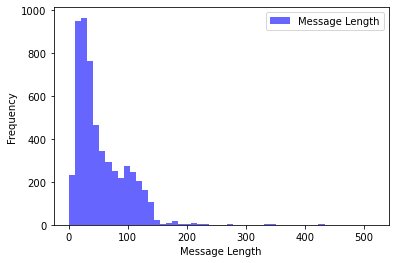

In [13]:
#A quick look at the histogram of data
X_train['length'].plot(bins=50, kind='hist', color='blue', 
                                       label='Message Length', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

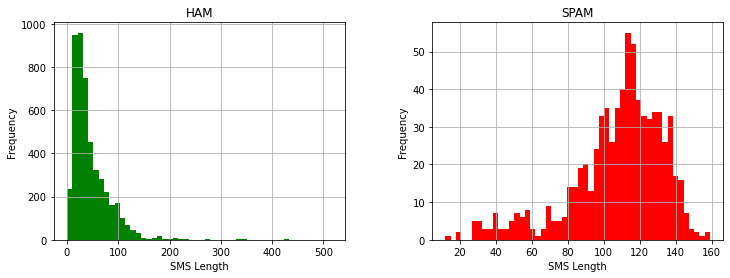

In [14]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

X_train[X_train['label']==0].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'SMS Length',ylabel = 'Frequency',title = 'HAM')
X_train[X_train['label']==1].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'SMS Length',ylabel = 'Frequency',title = 'SPAM');

Now, fetch the feature and target in X and Y. After that take the 10% of data for testing set.

# Model Exploration:
### 1. Features created using TfidfVectorizer 

In [15]:
X = X_train['pos_tag_sentence']
y = X_train['label']
# print(X,y)

In [16]:
X_trainData, X_testData, y_trainS, y_testS = train_test_split(
    X, y, test_size=0.1, random_state=1, shuffle=True)

Convert all text/string data of SMS to numerical features by using TfidfVectorizer.

In [17]:

vectorizer =TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_trainS= vectorizer.fit_transform(X_trainData)
X_testS = vectorizer.transform(X_testData)

Check the shape of training and testing data features and targets.

In [18]:
print(X_trainS.shape, y_trainS.shape, X_testS.shape, y_testS.shape)

(5014, 26) (5014,) (558, 26) (558,)


### 1.1: Logistic Regression (SGDClassifier) - Features created using TfidfVectorizer

In [19]:
model_SGDClassifier = SGDClassifier(eta0=0.1, max_iter=1000, tol=0.1, random_state=1, loss='log')#, penalty="l2")
model_SGDClassifier.fit(X_trainS, y_trainS.squeeze())

SGDClassifier(eta0=0.1, loss='log', random_state=1, tol=0.1)

In [20]:
# find prediction for training and testing set.
h_train = model_SGDClassifier.predict(X_trainS)
h_test = model_SGDClassifier.predict(X_testS)
# print("Prediction: ",h_train)


In [21]:
pred_scores = []

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)

print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)

print("\n>>>>>>>>>>Test Performance<<<<<<<<<<")
print("Test Confusion Matrix:\n", cf_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))
print("Test Precision {0:0.2%}".format(ps_test))
print("Test Recall {0:0.2%}".format(rs_test))
print("Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SGDClassifier_TfidfVectorizer",f1_test))


>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4129  206]
 [ 206  473]]
Train Accuracy: 91.78%
Train Precision 82.45%
Train Recall: 82.45%
Train F1: 82.45%

>>>>>>>>>>Test Performance<<<<<<<<<<
Test Confusion Matrix:
 [[462  28]
 [ 16  52]]
Test Accuracy: 92.11%
Test Precision 80.83%
Test Recall 85.38%
Test F1: 82.86%


### 1.2: Tuning models (Logistic Regression) with GridSearch to find the best parameters - Features created using TfidfVectorizer 

In [22]:
model = SGDClassifier(eta0=0.3, max_iter=1000, tol=0.1, random_state=1, loss='log', penalty="l2")
f1_scores = cross_val_score(model, X_trainS, y_trainS.squeeze(), scoring='f1', cv=10 )
print("CV F1 scores: ", f1_scores)
print("Average F1: {0:0.2%}".format(np.mean(f1_scores)))

CV F1 scores:  [0.68493151 0.68085106 0.66197183 0.67741935 0.57627119 0.58928571
 0.6984127  0.6875     0.68531469 0.6962963 ]
Average F1: 66.38%


In [23]:
start = time.time()

model = SGDClassifier(tol=0.1, random_state=1, loss='log')
param_grid = [
                {'learning_rate': ['invscaling', 'adaptive'],
                 'eta0': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                 'max_iter': [1000, 2000, 3000, 4000, 5000], 
                }
]

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', refit=True)
grid_search.fit(X_trainS, y_trainS.squeeze())
print(grid_search.best_params_)
print(f'Time: {time.time() - start}')

{'eta0': 0.9, 'learning_rate': 'adaptive', 'max_iter': 1000}
Time: 12.057932376861572


In [24]:
best_model = grid_search.best_estimator_


h_train = model_SGDClassifier.predict(X_trainS)
h_test = best_model.predict(X_testS)

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)

print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)


print("\n>>>>>>>>>>Test Performance<<<<<<<<<<")
print("Test Confusion Matrix:\n", cf_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))
print("Test Precision {0:0.2%}".format(ps_test))
print("Test Recall {0:0.2%}".format(rs_test))
print("Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SGDClassifier_GS_TfidfVectorizer",f1_test))

>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4129  206]
 [ 206  473]]
Train Accuracy: 91.78%
Train Precision 82.45%
Train Recall: 82.45%
Train F1: 82.45%

>>>>>>>>>>Test Performance<<<<<<<<<<
Test Confusion Matrix:
 [[468  22]
 [ 21  47]]
Test Accuracy: 92.29%
Test Precision 81.91%
Test Recall 82.31%
Test F1: 82.11%


### 1.3: Shallow Neural Network (SNN) - Features created using TfidfVectorizer 

In [25]:
print(X_trainS.shape, y_trainS.shape, X_testS.shape, y_testS.shape)

(5014, 26) (5014,) (558, 26) (558,)


In [26]:
K.clear_session()

start = time.time()


num_epochs=50

early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_SNN_model(X_trainS.shape[1],0.1)
history = model.fit(X_trainS,
                   y_trainS,
                   epochs=num_epochs,
                   verbose=0,
                   validation_split=0.1,
                   callbacks=callbacks_list)
history_dict = history.history
history_dict.keys()

print(f'Time: {time.time() - start}')

Time: 11.478394269943237


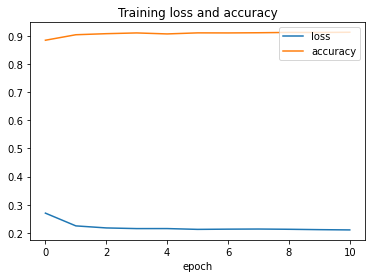

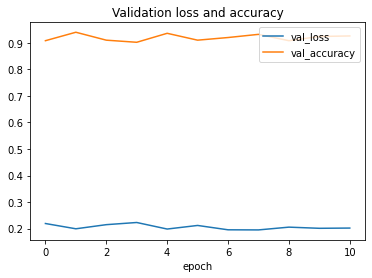

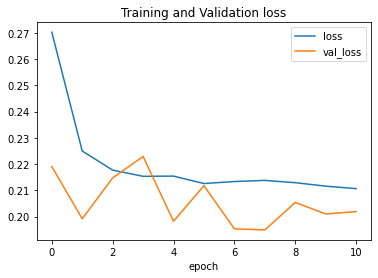

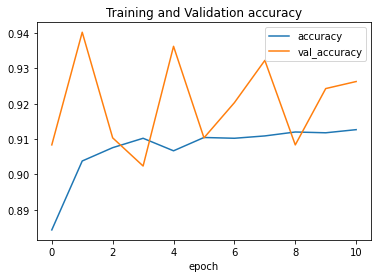

In [27]:
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['accuracy'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_accuracy'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['accuracy'])
tarin_val_loss_ax.plot(history.history['val_accuracy'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')


plt.show()

In [28]:
# Prdict the train and test data.
h_train,h_test = predict(X_trainS,X_testS)

In [29]:
cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)


print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SNN_TfidfVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4164  171]
 [ 263  416]]
Average Train Accuracy: 91.34%
Average Train Precision 82.46%
Average Train Recall: 78.66%
Average Train F1: 80.38%
Training Performance
Average Test Confusion Matrix:
 [[470  20]
 [ 26  42]]
Average Test Accuracy: 91.76%
Average Test Precision 81.25%
Average Test Recall 78.84%
Average Test F1: 79.98%


### 1.4: Deep Neural Network (DNN) - Features created using TfidfVectorizer 

In [30]:

K.clear_session()
start = time.time()


early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_DNN_model(X_trainS.shape[1],0.1)


history =model.fit(X_trainS,
                   y_trainS,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 3s 607us/step - loss: 0.3692 - accuracy: 0.8797 - val_loss: 0.3276 - val_accuracy: 0.8825
Epoch 2/50
4512/4512 [==============================] - 2s 397us/step - loss: 0.2845 - accuracy: 0.9054 - val_loss: 0.2483 - val_accuracy: 0.9064
Epoch 3/50
4512/4512 [==============================] - 2s 405us/step - loss: 0.2577 - accuracy: 0.9102 - val_loss: 0.2076 - val_accuracy: 0.9243
Epoch 4/50
4512/4512 [==============================] - 2s 401us/step - loss: 0.2577 - accuracy: 0.9076 - val_loss: 0.2052 - val_accuracy: 0.9263
Epoch 5/50
4512/4512 [==============================] - 2s 395us/step - loss: 0.2570 - accuracy: 0.9136 - val_loss: 0.2115 - val_accuracy: 0.9183
Epoch 6/50
4512/4512 [==============================] - 2s 399us/step - loss: 0.2411 - accuracy: 0.9189 - val_loss: 0.2088 - val_accuracy: 0.9303
Epoch 7/50
4512/4512 [==============================] - 2s 398us/step - loss:

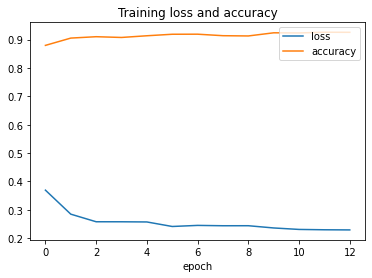

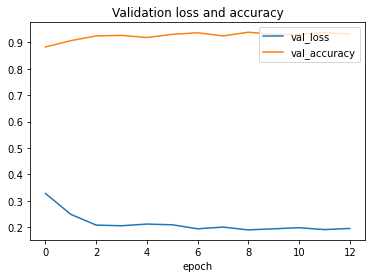

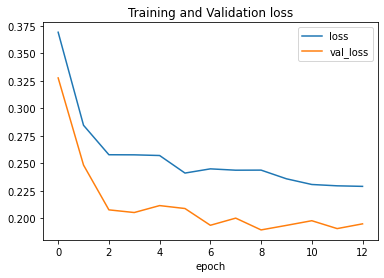

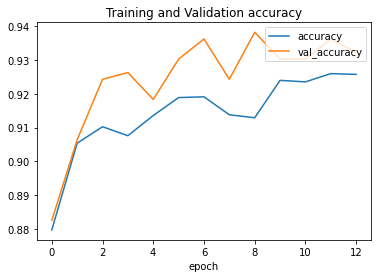

In [31]:
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['accuracy'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_accuracy'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['accuracy'])
tarin_val_loss_ax.plot(history.history['val_accuracy'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')


plt.show()

In [32]:
h_train,h_test=predict(X_trainS,X_testS)

In [33]:

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)


print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)


print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("DNN_TfidfVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4286   49]
 [ 245  434]]
Average Train Accuracy: 94.14%
Average Train Precision 92.22%
Average Train Recall: 81.39%
Average Train F1: 85.69%
Training Performance
Average Test Confusion Matrix:
 [[484   6]
 [ 27  41]]
Average Test Accuracy: 94.09%
Average Test Precision 90.98%
Average Test Recall 79.53%
Average Test F1: 84.00%


### 1.5: DecisionTreeClassifier - Features created using TfidfVectorizer 

In [34]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(X_trainS, y_trainS)

DecisionTreeClassifier(random_state=50)

In [35]:
dt_p_train = dt.predict(X_trainS)
print(dt_p_train.shape,y_testS.shape)

(5014,) (558,)


In [36]:
cm = confusion_matrix(y_trainS, dt_p_train)

print(cm)

[[4326    9]
 [ 132  547]]


In [37]:
target_names = ['ham', 'spam']
print ("Accuracy :: {0:0.2%} \n\n" .format(accuracy_score(y_testS, dt.predict(X_testS))))
print (classification_report(y_testS, dt.predict(X_testS),target_names=target_names))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,dt_p_train)
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)


pred_scores.append(("DecisionTreeClassifier_TfidfVectorizer",f1_test))

Accuracy :: 94.62% 


              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       490
        spam       0.81      0.74      0.77        68

    accuracy                           0.95       558
   macro avg       0.89      0.86      0.87       558
weighted avg       0.94      0.95      0.95       558

Average Train Confusion Matrix:
 [[4326    9]
 [ 132  547]]
Average Train Accuracy: 97.19%
Average Train Precision 97.71%
Average Train Recall: 90.18%
Average Train F1: 93.49%


### 2. Features created using CountVectorizer 

In [38]:
XCV = X_train['sms']
ycv = X_train['label']

In [39]:

X_trainCV, X_testCV, y_trainCV, y_testCV = train_test_split(XCV, 
                                                    ycv,test_size=0.10, shuffle=True,
                                                    random_state=1)
unique, counts = np.unique(y_testCV, return_counts=True)
dict(zip(unique, counts))

{0: 490, 1: 68}

In [40]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_trainCV)

#count_vector.get_feature_names()
# Transform testing data and return the matrix. 
testing_data = count_vector.transform(X_testCV)


### 2.1. Multinomial Naive Bayes - Features created using CountVectorizer 

In [41]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_trainCV)

MultinomialNB()

In [42]:
predictions = naive_bayes.predict(testing_data)

In [43]:
print(y_testCV.shape,predictions.shape)

(558,) (558,)


In [44]:
print('Accuracy score: {0:0.2%}'.format(accuracy_score(y_testCV, predictions)))
print('Precision score: {0:0.2%}'.format(precision_score(y_testCV, predictions)))
print('Recall score: {0:0.2%}'.format(recall_score(y_testCV, predictions)))
print('F1 score: {0:0.2%}'.format(f1_score(y_testCV, predictions)))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,predictions)
pred_scores.append(("MultiNB_CountVectorizer",f1_test))

Accuracy score: 98.39%
Precision score: 94.03%
Recall score: 92.65%
F1 score: 93.33%


### 2.2.  Logistic Regression (SGDClassifier)  - Features created using CountVectorizer 

In [45]:
model_SGDClassifier = SGDClassifier(eta0=0.1, max_iter=1000, tol=0.1, random_state=1, loss='log')#, penalty="l2")
model_SGDClassifier.fit(training_data, y_trainCV.squeeze())

SGDClassifier(eta0=0.1, loss='log', random_state=1, tol=0.1)

In [46]:
h_train = model_SGDClassifier.predict(training_data)
h_test = model_SGDClassifier.predict(testing_data)

In [47]:
cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)

print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("\n>>>>>>>>>>Test Performance<<<<<<<<<<")
print("Test Confusion Matrix:\n", cf_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))
print("Test Precision {0:0.2%}".format(ps_test))
print("Test Recall {0:0.2%}".format(rs_test))
print("Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SGDClassifier_CountVectorizer",f1_test))

>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4333    2]
 [   4  675]]
Train Accuracy: 99.88%
Train Precision 99.81%
Train Recall: 99.68%
Train F1: 99.74%

>>>>>>>>>>Test Performance<<<<<<<<<<
Test Confusion Matrix:
 [[490   0]
 [  5  63]]
Test Accuracy: 99.10%
Test Precision 99.49%
Test Recall 96.32%
Test F1: 97.84%


### 2.3.  GridSearch to find the best parameters - Features created using CountVectorizer 

In [48]:
start = time.time()
model = SGDClassifier(tol=0.1, random_state=1, loss='log')
param_grid = [
                {'learning_rate': ['invscaling', 'adaptive'],
                 'eta0': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                 'max_iter': [1000, 2000, 3000, 4000, 5000], 
                }
]

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', refit=True)
grid_search.fit(training_data, y_trainCV.squeeze())
print(grid_search.best_params_)
print(f'Time: {time.time() - start}')

{'eta0': 0.4, 'learning_rate': 'adaptive', 'max_iter': 1000}
Time: 16.733672857284546


In [49]:
best_model = grid_search.best_estimator_

h_train = best_model.predict(training_data)
h_test = best_model.predict(testing_data)

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)

cf,ca,ps,rs,f1=matrix(y_testCV,h_test)

print(">>>>>>>>>> Test Performance <<<<<<<<<")
print("Accuracy: {0:0.2%}".format(ca))
print("Confusion Matrix:\n", cf)
print("Precision: {0:0.2%}".format(ps))
print("Recall:    {0:0.2%}".format(rs))
print("F1:        {0:0.2%}".format(f1))
pred_scores.append(("SGDClassifier_GS_CountVectorizer",f1))

>>>>>>>>>> Test Performance <<<<<<<<<
Accuracy: 98.75%
Confusion Matrix:
 [[490   0]
 [  7  61]]
Precision: 99.30%
Recall:    94.85%
F1:        96.93%


### 2.4. Shallow Neural Network (SNN) - Features created using CountVectorizer 

In [50]:
num_epochs = 50

start = time.time()
early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_SNN_model(training_data.shape[1],0.1)
history = model.fit(training_data,
                   y_trainCV,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
history_dict = history.history
history_dict.keys()
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.1791 - accuracy: 0.9351 - val_loss: 0.0949 - val_accuracy: 0.9701
Epoch 2/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0536 - accuracy: 0.9829 - val_loss: 0.0781 - val_accuracy: 0.9761
Epoch 3/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.0622 - val_accuracy: 0.9781
Epoch 4/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0110 - accuracy: 0.9982 - val_loss: 0.0653 - val_accuracy: 0.9821
Epoch 5/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.0650 - val_accuracy: 0.9781
Epoch 6/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.0632 - val_accuracy: 0.9781
Epoch 7/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0023

In [51]:
h_train,h_test=predict(training_data,testing_data)

In [52]:
cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)

print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SNN_CountVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4334    1]
 [   9  670]]
Average Train Accuracy: 99.80%
Average Train Precision 99.82%
Average Train Recall: 99.33%
Average Train F1: 99.57%
Training Performance
Average Test Confusion Matrix:
 [[490   0]
 [  5  63]]
Average Test Accuracy: 99.10%
Average Test Precision 99.49%
Average Test Recall 96.32%
Average Test F1: 97.84%


### 2.5. Deep Neural Network (DNN) - Features created using CountVectorizer 

In [53]:
K.clear_session()

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_DNN_model(training_data.shape[1],0.1)


history =model.fit(training_data,
                   y_trainCV,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 16s 4ms/step - loss: 0.2921 - accuracy: 0.9317 - val_loss: 0.1791 - val_accuracy: 0.9562
Epoch 2/50
4512/4512 [==============================] - 17s 4ms/step - loss: 0.1694 - accuracy: 0.9694 - val_loss: 0.0951 - val_accuracy: 0.9821
Epoch 3/50
4512/4512 [==============================] - 16s 4ms/step - loss: 0.1389 - accuracy: 0.9741 - val_loss: 0.0881 - val_accuracy: 0.9861
Epoch 4/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1184 - accuracy: 0.9818 - val_loss: 0.0904 - val_accuracy: 0.9841
Epoch 5/50
4512/4512 [==============================] - 14s 3ms/step - loss: 0.1069 - accuracy: 0.9787 - val_loss: 0.0827 - val_accuracy: 0.9821
Epoch 6/50
4512/4512 [==============================] - 14s 3ms/step - loss: 0.1022 - accuracy: 0.9809 - val_loss: 0.0799 - val_accuracy: 0.9841
Epoch 7/50
4512/4512 [==============================] - 16s 4ms/step - loss: 0.0925

In [54]:
h_train,h_test=predict(training_data,testing_data)

In [55]:

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)

print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("DNN_CountVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4329    6]
 [  10  669]]
Average Train Accuracy: 99.68%
Average Train Precision 99.44%
Average Train Recall: 99.19%
Average Train F1: 99.32%
Training Performance
Average Test Confusion Matrix:
 [[490   0]
 [  9  59]]
Average Test Accuracy: 98.39%
Average Test Precision 99.10%
Average Test Recall 93.38%
Average Test F1: 96.00%


### 2.6. DecisionTreeClassifier - Features created using CountVectorizer 

In [56]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(training_data, y_trainCV)

DecisionTreeClassifier(random_state=50)

In [57]:
dt_p_train = dt.predict(training_data)
print(dt_p_train.shape,testing_data.shape)

(5014,) (558, 8882)


In [58]:
cm = confusion_matrix(y_trainCV, dt_p_train)

In [59]:

target_names = ['ham', 'spam']
print ("Accuracy :: {0:0.2%} \n\n" .format(accuracy_score(y_testCV, dt.predict(testing_data))))
print (classification_report(y_testS, dt.predict(testing_data),target_names=target_names))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,dt_p_train)
pred_scores.append(("DecisionTreeClassifier_CountVectorizer",f1_train))

Accuracy :: 96.95% 


              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       490
        spam       0.92      0.82      0.87        68

    accuracy                           0.97       558
   macro avg       0.95      0.91      0.93       558
weighted avg       0.97      0.97      0.97       558



In [60]:
pred_scores

[('SGDClassifier_TfidfVectorizer', 0.8286240786240786),
 ('SGDClassifier_GS_TfidfVectorizer', 0.8211045085481237),
 ('SNN_TfidfVectorizer', 0.7997503510688095),
 ('DNN_TfidfVectorizer', 0.8400382226469183),
 ('DecisionTreeClassifier_TfidfVectorizer', 0.8400382226469183),
 ('MultiNB_CountVectorizer', 0.962079510703364),
 ('SGDClassifier_CountVectorizer', 0.9783779594683613),
 ('SGDClassifier_GS_CountVectorizer', 0.9693221177634834),
 ('SNN_CountVectorizer', 0.9783779594683613),
 ('DNN_CountVectorizer', 0.960016878577741),
 ('DecisionTreeClassifier_CountVectorizer', 1.0)]

In [61]:
df = pd.DataFrame(pred_scores) 
df

,0,1
0,SGDClassifier_TfidfVectorizer,0.828624
1,SGDClassifier_GS_TfidfVectorizer,0.821105
2,SNN_TfidfVectorizer,0.799750
3,DNN_TfidfVectorizer,0.840038
4,DecisionTreeClassifier_TfidfVectorizer,0.840038
5,MultiNB_CountVectorizer,0.962080
6,SGDClassifier_CountVectorizer,0.978378
7,SGDClassifier_GS_CountVectorizer,0.969322
8,SNN_CountVectorizer,0.978378
9,DNN_CountVectorizer,0.960017


### Plotting the F1 score on testing set:

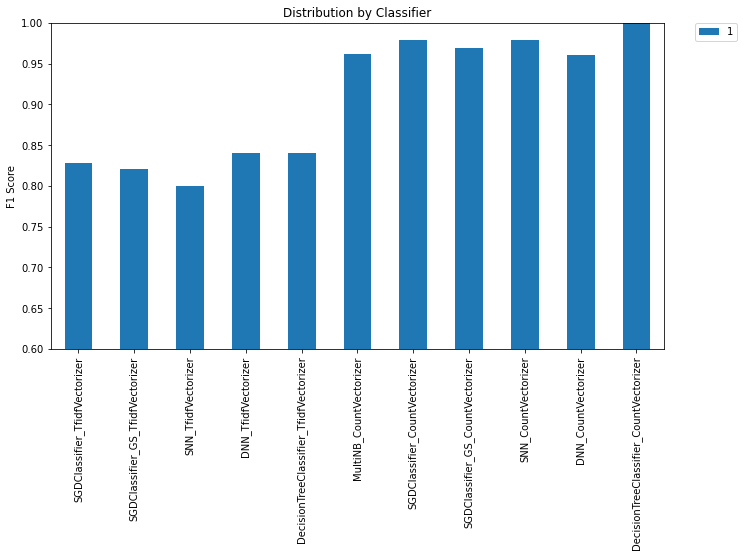

In [62]:
df.plot(kind='bar', ylim=(0.6,1.0), figsize=(11,6), align='center')
plt.xticks(np.arange(11), df[0])
plt.ylabel('F1 Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



### Conclusion:
- From simulation results, it clearly see that if we vectorize the data using CountVectorizer then Logistic Regression and DNN is showing best results.
- The overall accuracy 99.10% and 98.92% respective for using CountVectorizer then Logistic Regression and DNN. Also, the F1 score is higher for these two models.
